# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os


In [ ]:
print(tf.config.list_physical_devices('GPU'))


[]


In [ ]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)

(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    #data_dir='D:\progetto-daml\\new_dataset',
    with_info=True,
    #download=False
)

'''
builder = tfds.builder('plant_village')
builder.download_and_prepare()  # un solo download + prepare
ds_info = builder.info

ds_train = builder.as_dataset(split='train[:80%]', as_supervised=True, shuffle_files=True, with_info=True)
ds_val   = builder.as_dataset(split='train[80%:90%]', as_supervised=True, shuffle_files=True, with_info=True)
ds_test  = builder.as_dataset(split='train[90%:]', as_supervised=True, shuffle_files=True, with_info=True)
'''

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.68I56K_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


"\nbuilder = tfds.builder('plant_village')\nbuilder.download_and_prepare()  # un solo download + prepare\nds_info = builder.info\n\nds_train = builder.as_dataset(split='train[:80%]', as_supervised=True, shuffle_files=True, with_info=True)\nds_val   = builder.as_dataset(split='train[80%:90%]', as_supervised=True, shuffle_files=True, with_info=True)\nds_test  = builder.as_dataset(split='train[90%:]', as_supervised=True, shuffle_files=True, with_info=True)\n"

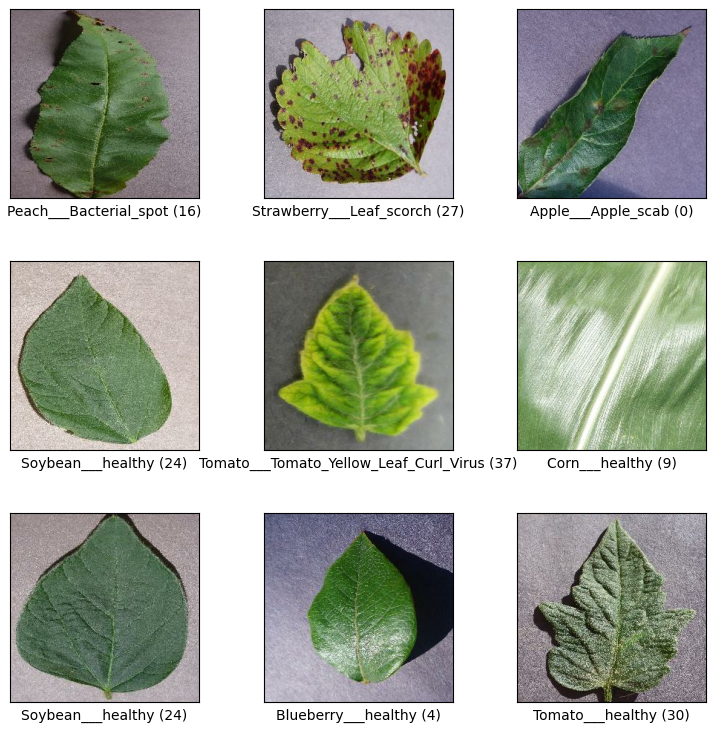

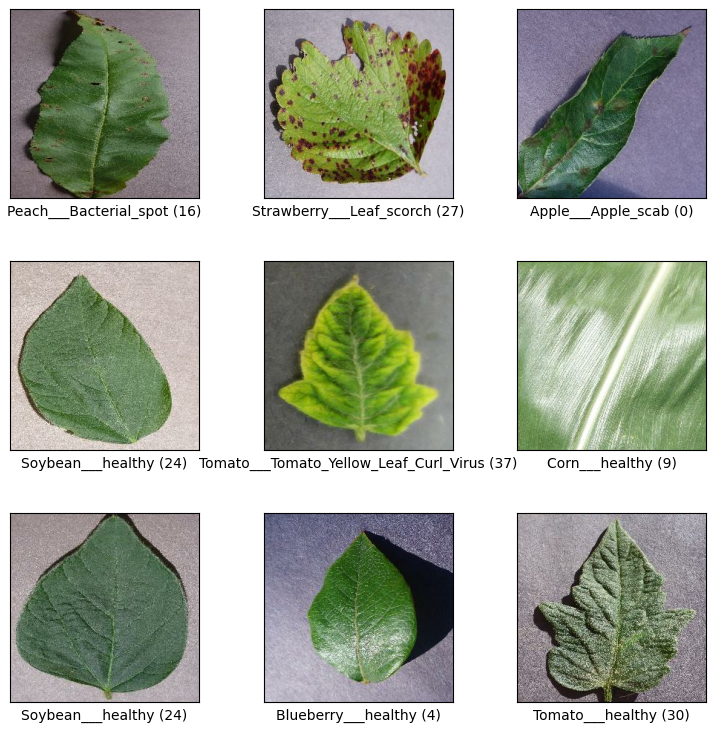

In [ ]:
# Show example from the dataset
tfds.show_examples(ds_train, ds_info)


In [ ]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
APPLY_DATA_AUGMENTATION = False
N_EPOCHS = 12
VERBOSE = False


In [ ]:
data_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal"),
    # tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_with_aug(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = data_augmentation(image)  # <-- augment here
    image = tf.cast(image, tf.float32) / 255.0
    return image, label



In [ ]:
# Preprocess and batch the datasets
'''if APPLY_DATA_AUGMENTATION:
    print("Data augmentation is enabled.")
    train_ds = ds_train.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
else:
    print("Data augmentation is disabled.")
    train_ds = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation

val_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)'''


'if APPLY_DATA_AUGMENTATION:\n    print("Data augmentation is enabled.")\n    train_ds = ds_train.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation\nelse:\n    print("Data augmentation is disabled.")\n    train_ds = ds_train.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation\n\nval_ds = ds_val.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)\ntest_ds = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)'

In [ ]:
if VERBOSE:
  class_names = ds_info.features['label'].names
  print(class_names)


['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___

In [ ]:
#families counter
if VERBOSE:
  counter = 0
  families = sorted({name.split('___')[0] for name in class_names})
  print(families)
  print(len(families))

  NUM_FAM = len(families)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
14


In [ ]:
#index assignment for each family
family_map = [
    families.index(name.split('___')[0])
    for name in class_names
]

family_map = tf.constant(family_map, dtype=tf.int32)

if VERBOSE:
  print(family_map)


tf.Tensor(
[ 0  0  0  0  1  2  2  3  3  3  3  4  4  4  4  5  6  6  7  7  8  8  8  9
 10 11 12 12 13 13 13 13 13 13 13 13 13 13], shape=(38,), dtype=int32)


In [ ]:
#folder name -> family index (Apple = 1, Blueberry = 2 etc.)
def folder_to_fam_ohe(image, folder_label):
  fam_index = tf.gather(family_map, folder_label)
  fam_ohe = tf.one_hot(fam_index, NUM_FAM)
  return image, fam_ohe

ds_train_fam = ds_train.map(folder_to_fam_ohe)
ds_val_fam = ds_val.map(folder_to_fam_ohe)
ds_test_fam = ds_test.map(folder_to_fam_ohe)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Resizing, Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
#model definition
def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                num_classes=14):
    model = Sequential([
        Resizing(128, 128, input_shape=(None, None, 3)),
        # Rescaling(1./255, input_shape=input_shape),
        Conv2D(16, (5, 5), padding='same'),
        # BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        # Dropout(0.2),
        Conv2D(32, (5, 5), padding='same'),
        # BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        # Dropout(0.2),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


'''
def simple_cnn(num_classes=38):
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    #x = Rescaling(1./255, name='rescale')(inputs)
    x = Conv2D(16, (3, 3), name='conv_1', padding="same")(inputs)
    x = BatchNormalization(name='batch_norm_1')(x)
    x = Activation('relu',name='activ_1')(x)
    x = MaxPooling2D((2, 2),name='maxpool_1')(x)

    x = Conv2D(32, (3, 3), name='conv_2', padding='same')(x)
    x = BatchNormalization(name='batch_norm_2')(x)
    x = Activation('relu',name='activ_2')(x)
    x = MaxPooling2D((2, 2),name='maxpool_2')(x)
    x = Dropout(0.2,name='dropout_1')(x)

    x = Conv2D(128, (3, 3), name='conv_3', padding='same')(x)
    x = BatchNormalization(name='batch_norm_3')(x)
    x = Activation('relu',name='activ_3')(x)
    x = MaxPooling2D((2, 2),name='maxpool_3')(x)
    x = Dropout(0.3,name='dropout_2')(x)

    x = GlobalAveragePooling2D(name='global_avgpool')(x)
    x = Dropout(0.5,name='dropout_3')(x)

    x = Dense(num_classes, activation='softmax', name='fam_out')(x)

    model = Model(inputs=inputs, outputs=x)
    return model'''


'\ndef simple_cnn(num_classes=38):\n    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))\n    #x = Rescaling(1./255, name=\'rescale\')(inputs)\n    x = Conv2D(16, (3, 3), name=\'conv_1\', padding="same")(inputs)\n    x = BatchNormalization(name=\'batch_norm_1\')(x)\n    x = Activation(\'relu\',name=\'activ_1\')(x)\n    x = MaxPooling2D((2, 2),name=\'maxpool_1\')(x)\n\n    x = Conv2D(32, (3, 3), name=\'conv_2\', padding=\'same\')(x)\n    x = BatchNormalization(name=\'batch_norm_2\')(x)\n    x = Activation(\'relu\',name=\'activ_2\')(x)\n    x = MaxPooling2D((2, 2),name=\'maxpool_2\')(x)\n    x = Dropout(0.2,name=\'dropout_1\')(x)\n\n    x = Conv2D(128, (3, 3), name=\'conv_3\', padding=\'same\')(x)\n    x = BatchNormalization(name=\'batch_norm_3\')(x)\n    x = Activation(\'relu\',name=\'activ_3\')(x)\n    x = MaxPooling2D((2, 2),name=\'maxpool_3\')(x)\n    x = Dropout(0.3,name=\'dropout_2\')(x)\n\n    x = GlobalAveragePooling2D(name=\'global_avgpool\')(x)\n    x = Dropout(0.5,

In [ ]:
model = simple_cnn()
#model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,070 (66.68 KB)

 Trainable params: 17,070 (66.68 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train the model
if APPLY_DATA_AUGMENTATION:
    check_point_filename = 'best_model_w_augmentation.h5'
else:
    check_point_filename = 'best_model_wo_augmentation.h5'

In [ ]:
# Preprocess and batch the datasets
if APPLY_DATA_AUGMENTATION:
    print("Data augmentation is enabled.")
    ds_train_fam = ds_train_fam.map(preprocess_with_aug).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset with data augmentation
else:
    print("Data augmentation is disabled.")
    ds_train_fam = ds_train_fam.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation

ds_val_fam = ds_val_fam.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test_fam = ds_test_fam.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Data augmentation is disabled.


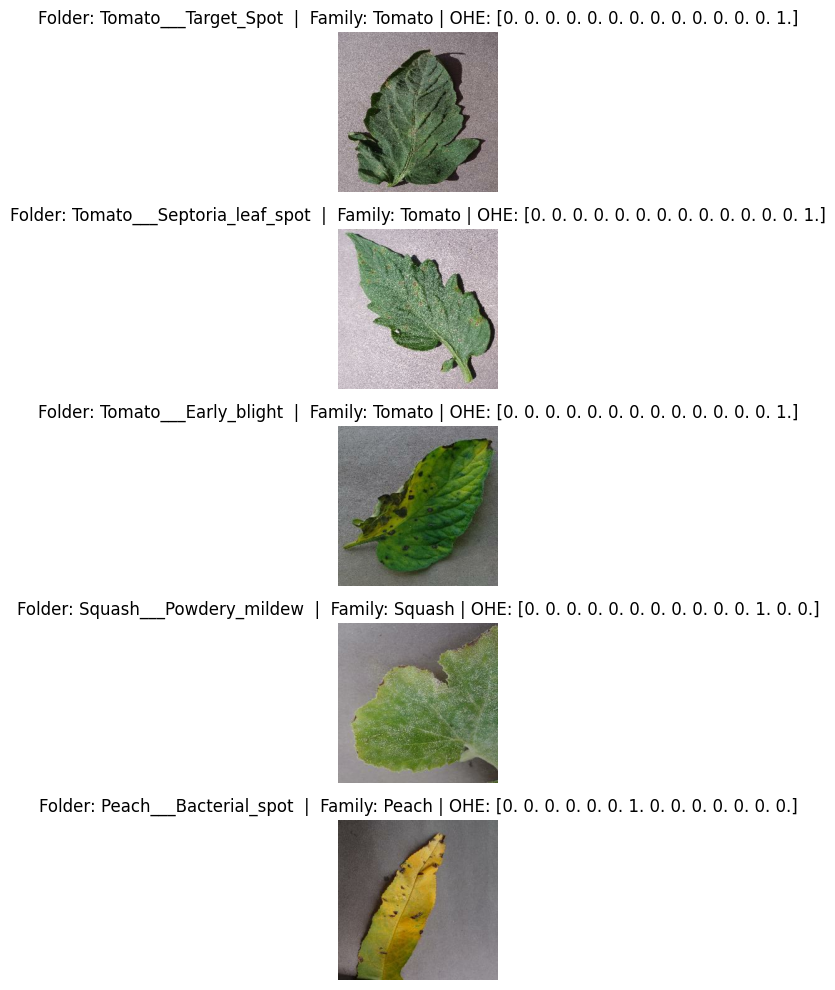

In [ ]:
def display_samples_with_labels(dataset, num_samples=5):
  plt.figure(figsize=(10, 2 * num_samples))
  for i, (image, disease_label) in enumerate(dataset.take(num_samples)):
    d_label = disease_label.numpy()
    folder_name = class_names[d_label]
    fam_idx = family_map[d_label].numpy()
    family_name = families[fam_idx]
    fam_ohe = tf.one_hot(fam_idx, NUM_FAM)


    # Visualization options
    ax = plt.subplot(num_samples, 1, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.axis('off')
    plt.title(f"Folder: {folder_name}  |  Family: {family_name} | OHE: {fam_ohe}")
  plt.tight_layout()
  plt.show()

#Visualization of trains samples
display_samples_with_labels(ds_train)

In [ ]:
history = model.fit(
    ds_train_fam,
    validation_data=ds_val_fam,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ModelCheckpoint(check_point_filename, monitor='val_loss', save_best_only=True, verbose=1),
        # ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)

Epoch 1/12
 299/2716 ━━━━━━━━━━━━━━━━━━━━ 17:56 446ms/step - accuracy: 0.2741 - loss: 2.4436

KeyboardInterrupt: 

In [ ]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [ ]:
# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in ds_val_fam:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)

In [ ]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


In [ ]:
from plotting import plot_confusion_matrix

plt.figure()  # Set a larger figure size for better readability
plot_confusion_matrix(
    np.array(y_true),
    np.array(y_pred),
    classes=families,
    normalize=True,
    title="Confusion Matrix (Test Set)",
    cmap="plasma"
)
plt.tight_layout()  # Ensure labels and ticks are not cut off


In [ ]:
print(y_score.shape[1])

In [ ]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{families[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.show()


In [ ]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=families)
print(report)


# **PREVOIUS EVALUATION CODE**

In [ ]:
# Plot ROC AUC for each class (one-vs-rest)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the test set
y_true = []
y_score = []

for images, labels in ds_test_fam:
    y_true.append(labels.numpy())
    y_score.append(model.predict(images))

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute ROC AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_score[:, i])


In [ ]:
print(y_true.shape)

In [ ]:
# Plot ROC curve for each class, legend sorted by AUC score
plt.figure(figsize=(12, 12))

# Prepare list of (auc, i) and sort descending
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)

for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{families[i]} (AUC = {auc:.5f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# Plot confusion matrix for the test set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels for the test set
y_true = []
y_pred = []

for images, labels in ds_test_fam:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')


In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis',
            xticklabels=families, yticklabels=families)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


# Load the best model